I'm running a few sets of chains that are fitting the redMagic HOD to a shuffled SHAM, as well as SHAMs with assembly bias to see what happens. I want all the tests I want to do to be in one place. This notebook will do the following:
* Load the chain and plot the contours
* Calculate the MAP values
* Load the original HOD and clustering for the SHAM sample of interest. 
* Populate the halo catalog and calculate its clustering.
* Plot the best fit clustering against the clustering in the fit
* Plot the best fit HOD to the true HOD of the sample

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [58]:
import numpy as np
from chainconsumer import ChainConsumer

In [59]:
from astropy.table import Table
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf
from pearce.mocks import cat_dict
from pearce.mocks.customHODModels import *
from math import ceil

In [60]:
fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_wt_redmagic_z0.23_no_nd.npy'

In [61]:
chain = np.genfromtxt(fname )

In [62]:
n_walkers = 200
n_burn = 2000
n_params = chain.shape[1]

In [63]:
chain.shape[0]/n_walkers

4183

In [64]:
chain = chain[n_burn*n_walkers:, :]

In [65]:
chain.shape

(436600, 6)

In [66]:
param_names = [r'$\log{M_{min}}$',r'$f_c$', r'$\log{M_0}$',r'$\sigma_{log{M}}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$f_{sat}$',r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']

In [67]:
c = ChainConsumer()
c.add_chain(chain, parameters=param_names, walkers=n_walkers)
#c.configure(statistics='cumulative')

In [68]:
gelman_rubin_converged = c.diagnostic.gelman_rubin()
print gelman_rubin_converged

Gelman-Rubin Statistic values for chain 0
$\log{M_{min}}$: 0.99978 (Passed)
$f_c$: 0.99979 (Passed)
$\log{M_0}$: 0.99978 (Passed)
$\sigma_{log{M}}$: 0.99982 (Passed)
$\log{M_1}$: 0.99978 (Passed)
$\alpha$: 0.99978 (Passed)
True


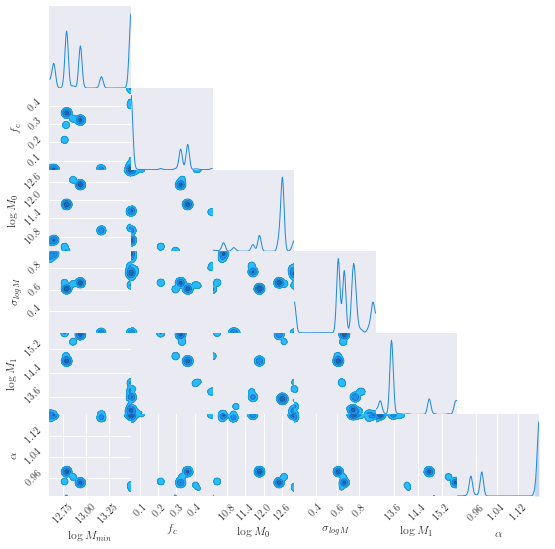

In [69]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names)
fig.show()

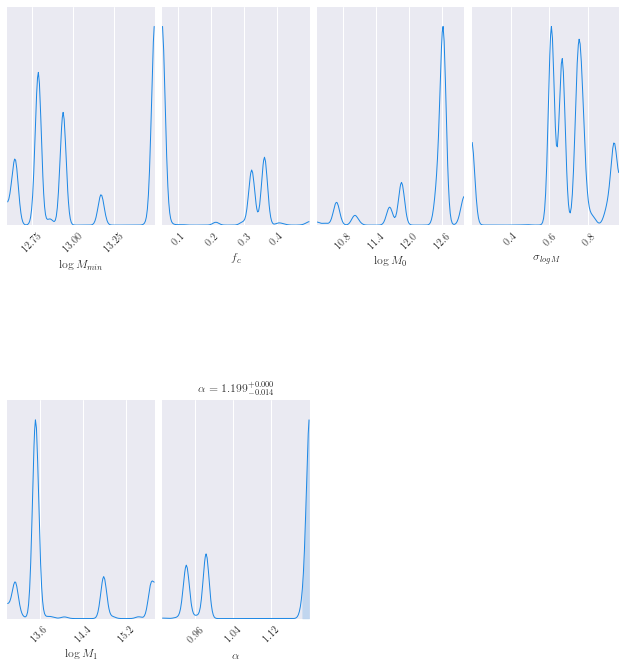

In [70]:
fig = c.plotter.plot_distributions(figsize=(10,10) )
fig.show()

In [71]:
summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
print MAP

[ 13.49651184   0.05173136  12.61269627   0.6098835   13.52247607
   1.19880891]


In [72]:
a = 0.81120
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#cat.h = 1.0

In [73]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy', rp_bins)

In [74]:
cat.load_model(a, HOD='redMagic')
#cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
#                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
#                                                               'cen_hod_vals':cen_hod_sham,
#                                                               'sat_hod_vals':sat_hod_sham})

In [75]:
cat.model.param_dict

{'alpha': 1.02,
 'f_c': 0.19,
 'logM0': 12.2,
 'logM1': 13.7,
 'logMmin': 12.1,
 'sigma_logM': 0.46}

In [76]:
#summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
#MAP = np.zeros((len(param_names),))
#MAP = chain[np.random.randint(chain.shape[0]), :]
print MAP

[ 13.49651184   0.05173136  12.61269627   0.6098835   13.52247607
   1.19880891]


In [77]:
param_names

['$\\log{M_{min}}$',
 '$f_c$',
 '$\\log{M_0}$',
 '$\\sigma_{log{M}}$',
 '$\\log{M_1}$',
 '$\\alpha$']

In [78]:
#names = ['mean_occupation_satellites_assembias_split1','mean_occupation_satellites_assembias_param1',
#          'mean_occupation_centrals_assembias_split1', 'mean_occupation_centrals_assembias_param1']

names = ['logMmin','f_c','logM0','sigma_logM', 'logM1', 'alpha']

In [79]:
params = dict(zip(names, MAP))
params['alpha'] = 1.0
#params = cat.model.param_dict
cat.calc_analytic_nd(params)

0.00060633654990933027

In [80]:
cat.populated_once = False
cat.populate(params)

In [81]:
cat.model.param_dict

{'alpha': 1.0,
 'f_c': 0.051731357194411173,
 'logM0': 12.612696269756569,
 'logM1': 13.52247606509826,
 'logMmin': 13.49651183971598,
 'sigma_logM': 0.60988349911502571}

In [82]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [83]:
wt_hod = cat.calc_wt(theta_bins)
print wt_hod
#wp_hod = cat.calc_xi(rp_bins, do_jackknife=False)

[  2.46309686e+01   1.92095199e+01   1.59851380e+01   1.13538012e+01
   7.99948427e+00   5.27457405e+00   2.91951288e+00   1.74764121e+00
   1.05374761e+00   7.17188832e-01   4.57051232e-01   2.95902086e-01
   3.18481429e-01   2.59729585e-01   1.76982375e-01   1.61820101e-01
   1.21027183e-01   8.98650872e-02   5.97124969e-02   1.35791832e-02]


In [84]:
wt_data = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_11.npy')

In [85]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s_%s_wp.npy'%(mag_type, shuffle_type), wp_sham)
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_vpeak_shuffled_nd.npy',np.array([cat.calc_analytic_nd()]) )

In [86]:
data_nd = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_nd_11.npy')
hod_nd = cat.calc_analytic_nd()

In [87]:
print data_nd

0.000298352370804


In [88]:
print hod_nd

0.000606336549909


In [89]:
print data_nd/hod_nd

0.492057374488


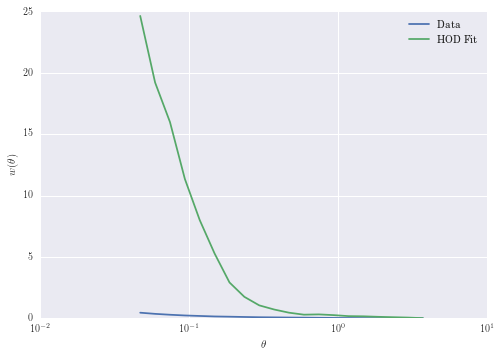

In [90]:
plt.plot(tpoints, wt_data, label = 'Data')
plt.plot(tpoints, wt_hod, label = 'HOD Fit')
#plt.loglog()
plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$w(\theta)$")
plt.show()

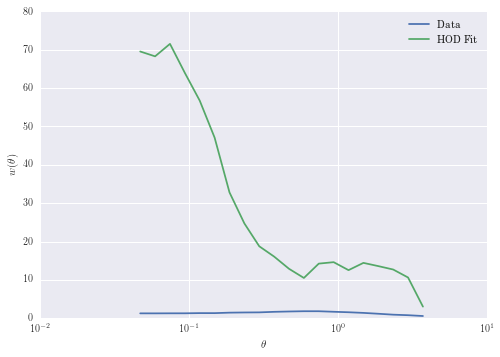

In [91]:
plt.plot(tpoints, tpoints*60*wt_data, label = 'Data')
plt.plot(tpoints, tpoints*60*wt_hod, label = 'HOD Fit')
#plt.loglog()
plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$w(\theta)$")
plt.show()

In [92]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [93]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wt_z/'

em_method = 'gp'
split_method = 'random'

load_fixed_params = {'z':1/a-1}

emu = ExtraCrispy(training_dir,10, 2, split_method, method=em_method, fixed_params=load_fixed_params)

In [94]:
#fixed_params = {'disp_func_slope_centrals':1.0,'disp_func_slope_satellites':1.0}#{'f_c':1.0}#,'logM1': 13.8 }# 'z':0.0}
em_params = params
#em_params.update(fixed_params)
wt_emu  = emu.emulate_wrt_r(em_params,tpoints)[0]

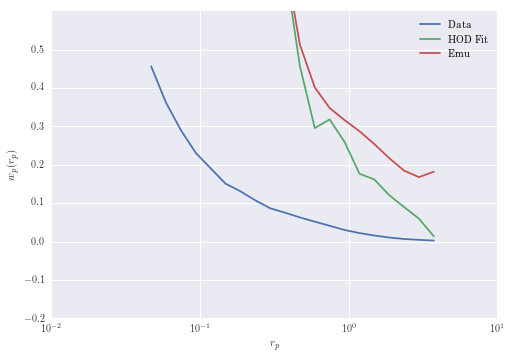

In [95]:
plt.plot(tpoints, wt_data, label = 'Data')
plt.plot(tpoints, wt_hod, label = 'HOD Fit')
plt.plot(tpoints, wt_emu, label = 'Emu')
plt.xscale('log')
plt.ylim([-0.2, 0.6])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

In [96]:
wt_hod

array([  2.46309686e+01,   1.92095199e+01,   1.59851380e+01,
         1.13538012e+01,   7.99948427e+00,   5.27457405e+00,
         2.91951288e+00,   1.74764121e+00,   1.05374761e+00,
         7.17188832e-01,   4.57051232e-01,   2.95902086e-01,
         3.18481429e-01,   2.59729585e-01,   1.76982375e-01,
         1.61820101e-01,   1.21027183e-01,   8.98650872e-02,
         5.97124969e-02,   1.35791832e-02])

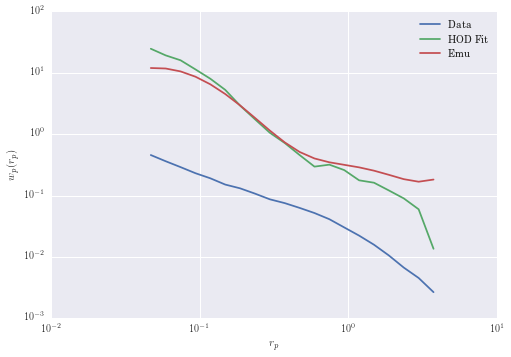

In [97]:
plt.plot(tpoints, wt_data, label = 'Data')
plt.plot(tpoints, wt_hod, label = 'HOD Fit')
plt.plot(tpoints, wt_emu, label = 'Emu')
plt.loglog()
#plt.xscale('log')
#plt.ylim([-0.2, 0.6])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

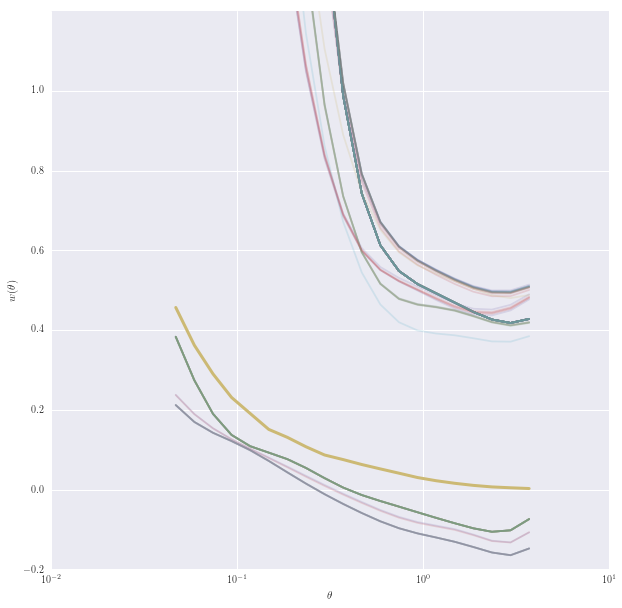

In [98]:
fig = plt.figure(figsize=(10,10))
for i in xrange(100):
    MAP = chain[np.random.randint(chain.shape[0]), :]
    em_params = dict(zip(names, MAP))
    #params['f_c'] = 1.0
    #cat.populated_once = False
    #cat.populate(params)
    wt_emu = emu.emulate_wrt_r(em_params,tpoints)[0]
    #wp_hod = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

    plt.plot(tpoints, wt_emu, alpha = 0.2)
    
plt.plot(tpoints, wt_data, lw = 3)


#plt.plot(rpoints, wp_sham, label = 'SHAM')
#MAP = np.array([0.5, 0.0,0.5, 0.0])
#params = dict(zip(names, MAP))
#cat.populate(params)
#wp_hod_noab = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

#plt.plot(rpoints, wp_hod_noab/wp_sham, ls = ':')

plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.ylim([-0.2, 1.2])
plt.legend(loc='best')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$w(\theta)$")
plt.show()